Добрый день. При автоматизации работы с документацией иногда приходится иметь дело со сканами плохого качества. Особенно удручает ситуация, при которой вместо сканированного документа предоставляется фото с телефона.

В области обработки документов существует целый ряд задач, которые решаются с помощью машинного обучения. С примерным списком можно ознакомиться в [данной статье](https://habr.com/ru/company/smartengines/blog/492696/). В этом руководстве я предлагаю решение проблемы размытости фото документа, которая может возникнуть при плохом качестве съемки.

Для борьбы с размытостью будем использовать модель, основанную на архитектуре генеративно-состязательной нейросети ([GAN](https://neurohive.io/ru/osnovy-data-science/gan-rukovodstvo-dlja-novichkov/)). В отличии от задач super-resolution (увлечение разрешения), данная модель оставляет исходным размер изображения.

Работать будем в облачном сервисе Google Collab.

Клонируем репозитории, которые нам понадобятся для запуска модели. 

In [ ]:
!git clone https://github.com/Cadene/pretrained-models.pytorch.git
!git clone https://github.com/VITA-Group/DeblurGANv2.git

Чтобы финальная модель заработала необходима подгрузка двух файлов с весами.

Сейчас наблюдается проблема с SSL-сертификатами сайта, на котором лежит первый файл с весами. Из-за этого возникает ошибка при инициализации модели. 

Поэтому скачаем веса с этого сайта вручную по данной ссылке http://data.lip6.fr/cadene/pretrainedmodels/inceptionresnetv2-520b38e4.pth. Вероятно, разработчики этого репозитория починят эту [проблему](https://github.com/Cadene/pretrained-models.pytorch/issues/222) в скором времени. Также сразу скачаем второй [файлик](https://drive.google.com/uc?export=view&id=1UXcsRVW-6KF23_TNzxw-xC0SzaMfXOaR) с весами.

Для удобства я разместил оба файла на своем гугл-диске в папку DeblurGANv2.



Подключаем гугл-диск к нашей файловой системе, чтобы иметь доступ к весам.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Копируем оба файла из с гугл-диска в наше пространство.

In [ ]:
!cp /content/drive/MyDrive/DeblurGANv2/fpn_inception.h5 /content/DeblurGANv2/fpn_inception.h5 
!cp /content/drive/MyDrive/DeblurGANv2/inceptionresnetv2-520b38e4.pth /content/DeblurGANv2/models/inceptionresnetv2-520b38e4.pth

Далее, чтобы обойти ошибку с сертификатами при загрузке весов модели с сайта,  заменим строчку кода в `inceptionresnetv2.py` с загрузкой модели по url-адрессу на строчку с инициализацией модели из файла, который мы скачали заранее.


In [ ]:
with open('/content/pretrained-models.pytorch/pretrainedmodels/models/inceptionresnetv2.py') as f:
    script = f.read()
    script = script.replace("model.load_state_dict(model_zoo.load_url(settings['url']))", 
                            "model.load_state_dict(torch.load('/content/DeblurGANv2/models/inceptionresnetv2-520b38e4.pth'))")
with open('/content/pretrained-models.pytorch/pretrainedmodels/models/inceptionresnetv2.py', 'w') as f:
    f.write(script)

Затем установим `pretrained-models` из репозитория. Так как мы немного изменили код для запуска модели, то я выведу последний коммит, на котором тестировал модель.

In [ ]:
%cd pretrained-models.pytorch
!git log -1 --pretty=format:"%h - %an" #8aae3d8 - Kamalesh Palanisamy
!python setup.py install
%cd ..

Для теста я подготовил несколько плохих фотографий текста на бумаге, которые тоже сохранил на гугл-диске.

In [ ]:
!mkdir test

!cp  /content/drive/MyDrive/DeblurGANv2/1.jpg test/1.jpg
!cp  /content/drive/MyDrive/DeblurGANv2/2.jpg test/2.jpg
!cp  /content/drive/MyDrive/DeblurGANv2/3.jpg test/3.jpg

Перейдём в директорию второго репозитория и тоже заменим пару строчек кода: изменим путь к папке с изображениями.

In [ ]:
%cd DeblurGANv2/
!git log -1 --pretty=format:"%h - %an"  #c16bd9f - Orest Kupyn

In [ ]:
with open('/content/DeblurGANv2/predict.py') as f:
    script = f.read()
    script = script.replace(r"os.walk(r'.\dataset1\blur')", 
                            "os.walk('/content/test')")
with open('/content/DeblurGANv2/predict.py', 'w') as f:
    f.write(script)

Установим необходимые библиотеки:

In [ ]:
!pip install -r requirements.txt
!pip install "opencv-python-headless<4.3"
!pip install -U PyYAML

И наконец запустим скрипт для обработки изображений:

In [ ]:
!python predict.py 

После отработки модели, обработанные картинки будут лежать в папке submit.

Создадим функцию для отрисовки полученного результата.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_pair_img(num_img):
    fig, ax = plt.subplots(1,2, figsize=(20, 20))

    img_lr = mpimg.imread(f'/content/test/{num_img}.jpg')
    img_hr = mpimg.imread(f'/content/DeblurGANv2/submit/{num_img}.jpg')

    ax[0].imshow(img_lr)
    ax[0].axis('off')
    ax[0].set_title('Before', fontsize = 20)

    ax[1].imshow(img_hr)
    ax[1].axis('off')
    ax[1].set_title('After', fontsize = 20);

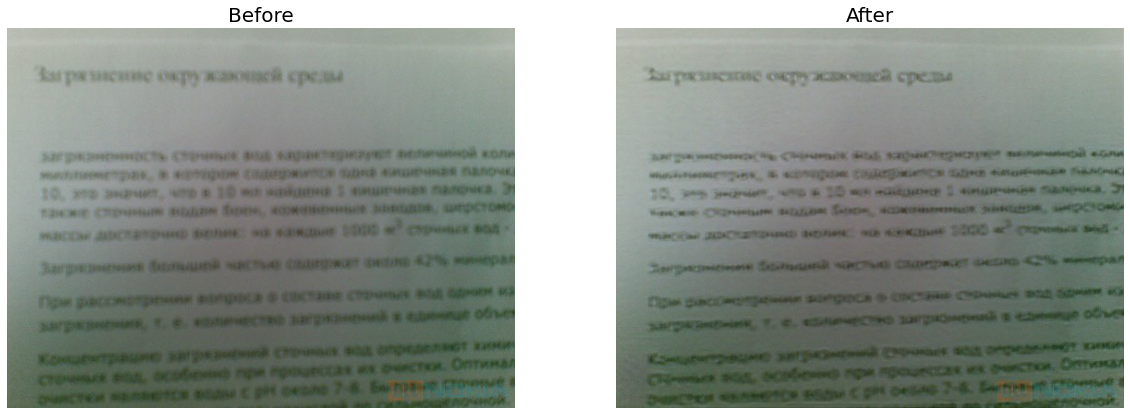

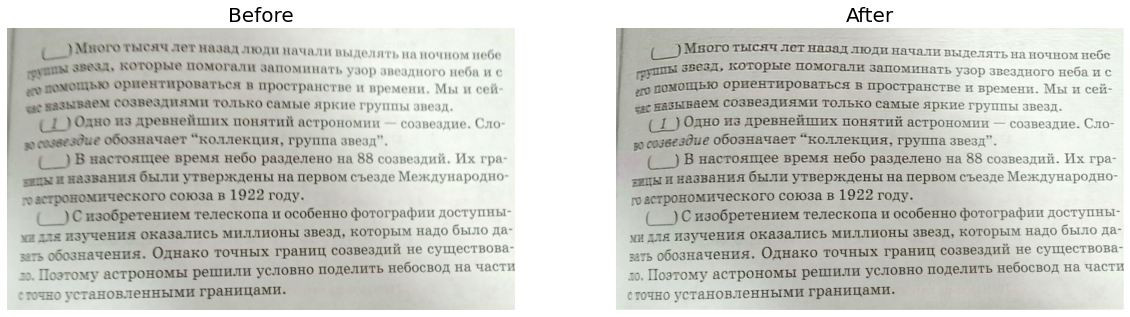

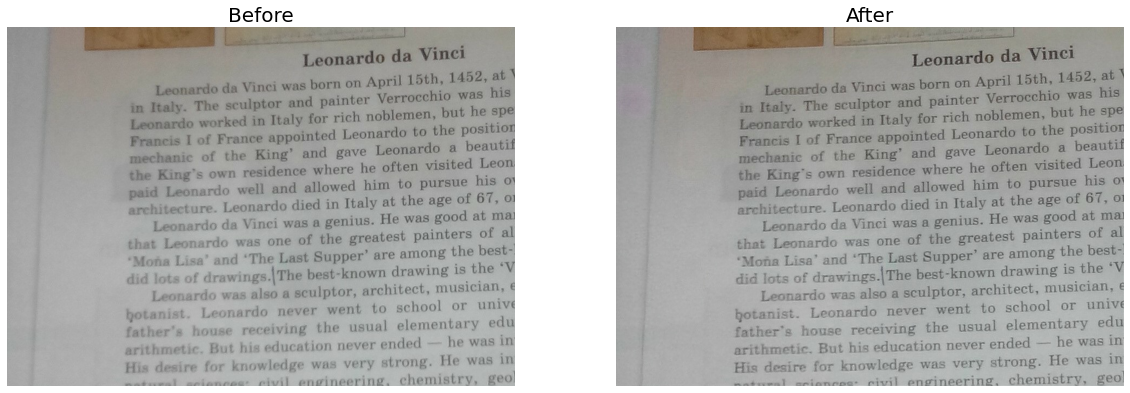

In [ ]:
for n in range(1, 4):
    show_pair_img(n)

С сильно размытыми изображениями модель справляется плохо, что видно на первой паре картинок. Однако на второй и третьей паре изображений заметно уменьшение размытости.

Таким образом данный подход может улучшить качество изображения документа для последующего извлечения признаков. Также этот метод можно использовать в связке с методом super-resolution для повышения качества изображения и последующей обработки.